ATMOSPHERIC FLOW ANALYSIS FOR INDIA
Step 1: Loading data...
Loading ERA5 datasets...
✓ Accumulated data loaded: ['tp']
✓ Instantaneous data loaded: ['u10', 'v10', 'd2m', 't2m', 'msl', 'sp']
✓ Wave data loaded: ['swh']

Combined dataset variables: ['tp', 'u10', 'v10', 'd2m', 't2m', 'msl', 'sp', 'swh']
Dimensions: {'valid_time': 2, 'latitude': 129, 'longitude': 121}
Coordinate names: ['valid_time', 'latitude', 'longitude', 'number', 'expver']

Step 2: Extracting variables...
Found u-wind: u10
Found v-wind: v10

Attempting to analyze closest data to Jan 1st: 2023-01-01 00:00:00
Attempting to analyze closest data to Jan 31st: 2023-01-31 00:00:00

ANALYZING FLOW FOR JANUARY 1st

Step 3: Creating flow network for Jan 1st...
Detected coordinates: time=valid_time, lat=latitude, lon=longitude
Original ranges:
  Time steps: 2
  Lat: 6.00 to 38.00 (129 points)
  Lon: 68.00 to 98.00 (121 points)
Analysis grid: 80x80 covering:
  Lat: 6.00 to 38.00
  Lon: 68.00 to 98.00
Synthetic topography created:

Tracking particles: 100%|██████████████████████████████████████████████████████████| 6400/6400 [01:39<00:00, 64.39it/s]


Transition matrix: 12248 non-zero elements

Step 4: Building network for Jan 1st...
Network: 5630 nodes, 9168 edges

Step 5: Calculating betweenness centrality for Jan 1st...

Betweenness centrality range (Jan 1st): 0.000000 to 0.000320

Step 6: Creating visualization for Jan 1st...

ERROR: Invalid format specifier '.6f if np.any(bet_grid > 0) else 0:.6f' for object of type 'float'

Troubleshooting tips:
1. Check that NetCDF files exist in the current directory.
2. Verify file names match exactly.
3. Ensure files contain wind data (u10, v10) with correct coordinate names (e.g., 'valid_time', 'latitude', 'longitude').
4. **CRITICAL**: Confirm the latitude/longitude ranges in your NetCDF data actually cover the region of India (approx. 68-98°E, 8-38°N). You confirmed updating your request to North: 38°, West: 68°, South: 6°, East: 98°. Make sure you've downloaded and are using *those* files (data_stream-oper_stepType-accum.nc, data_stream-oper_stepType-instant.nc, data_stream-wave_stepTy

Traceback (most recent call last):
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_34312\1299487912.py", line 541, in main
    plot_india_analysis(bet_grid_jan1, elevation, analysis_lat, analysis_lon, title_suffix=f"(at {jan1_actual_time.strftime('%Y-%m-%d %H:%M')})")
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_34312\1299487912.py", line 425, in plot_india_analysis
    • Mean centrality: {np.mean(bet_grid[bet_grid > 0]):.6f if np.any(bet_grid > 0) else 0:.6f}
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: Invalid format specifier '.6f if np.any(bet_grid > 0) else 0:.6f' for object of type 'float'


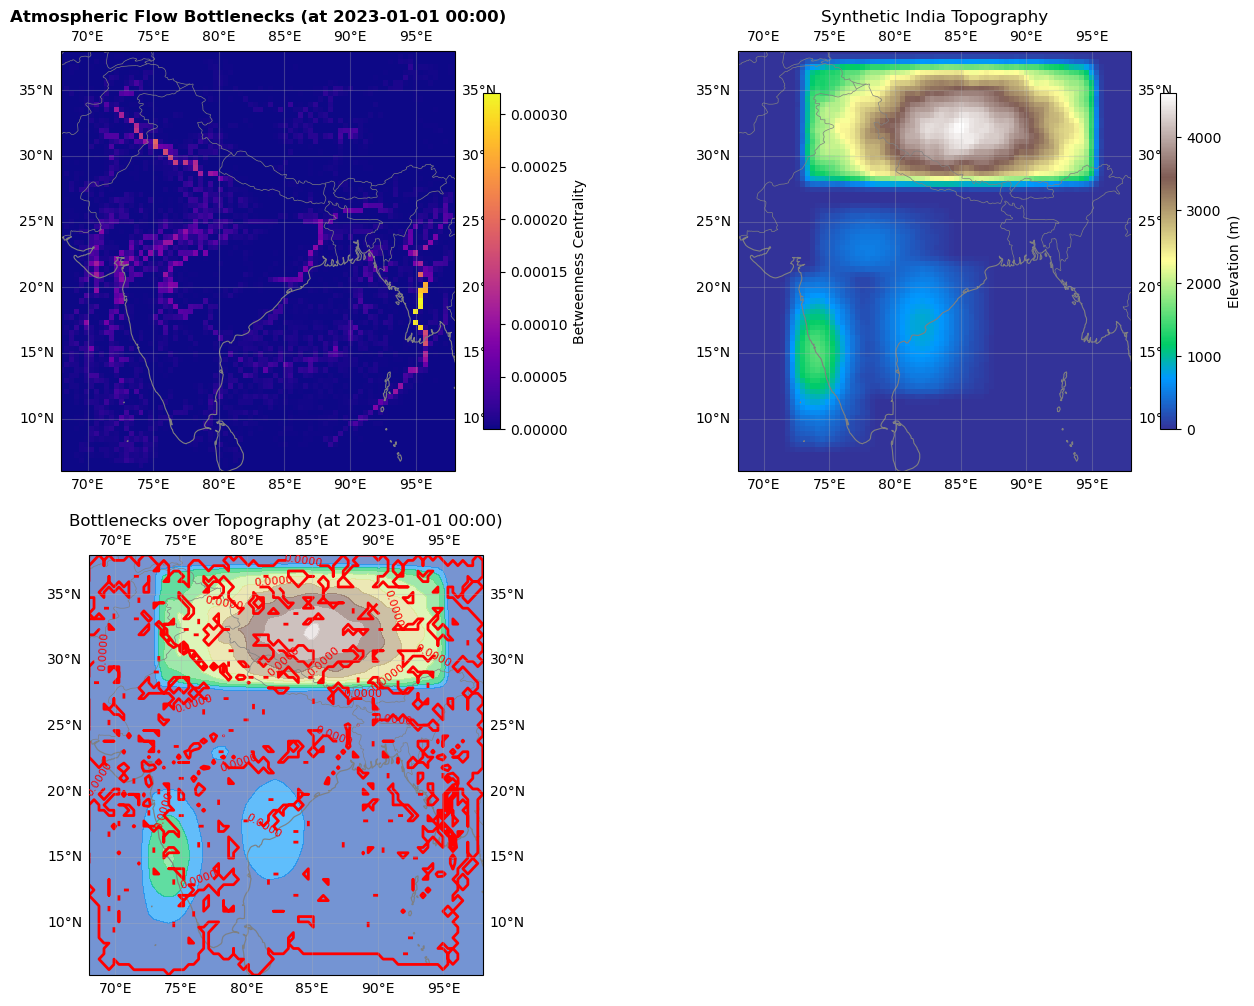

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
import xarray as xr
from scipy.ndimage import gaussian_filter
import warnings
import pandas as pd
import cartopy.crs as ccrs  # Import Cartopy
import cartopy.feature as cfeature # Import Cartopy features
warnings.filterwarnings('ignore')

# === Load and Merge All NetCDF Files ===
def load_enhanced_era5_data():
    """
    Load and merge all three ERA5 files with better error handling
    """
    print("Loading ERA5 datasets...")
    
    datasets = []
    file_configs = [
        ("data_stream-oper_stepType-accum.nc", "Accumulated"),
        ("data_stream-oper_stepType-instant.nc", "Instantaneous"), 
        ("data_stream-wave_stepType-instant.nc", "Wave")
    ]
    
    for filename, desc in file_configs:
        try:
            ds = xr.open_dataset(filename)
            datasets.append(ds)
            print(f"✓ {desc} data loaded: {list(ds.data_vars.keys())}")
        except FileNotFoundError:
            print(f"⚠ {desc} data file not found: {filename}")
        except Exception as e:
            print(f"✗ Error loading {desc} data: {e}")
    
    if not datasets:
        print("No NetCDF files found. Creating synthetic data for demonstration...")
        return create_synthetic_era5_data()
    
    # Merge datasets carefully
    if len(datasets) == 1:
        ds_combined = datasets[0]
    else:
        try:
            ds_combined = xr.merge(datasets, compat='override')
        except xr.MergeError as e:
            print(f"Merge error: {e}. Attempting merge with explicit coordinate handling.")
            main_ds = datasets[0]
            for other_ds in datasets[1:]:
                for var in other_ds.data_vars:
                    if var not in main_ds.data_vars:
                        main_ds[var] = other_ds[var]
            ds_combined = main_ds
            print("Merged by adding missing variables to the first dataset.")

    print(f"\nCombined dataset variables: {list(ds_combined.data_vars.keys())}")
    print(f"Dimensions: {dict(ds_combined.dims)}")
    print(f"Coordinate names: {list(ds_combined.coords.keys())}")
    
    return ds_combined

def create_synthetic_era5_data():
    """
    Create synthetic ERA5-like data for demonstration when real files are not available
    Simulates a month of data, allowing selection of Jan 1st and Jan 31st equivalent.
    """
    print("Creating synthetic ERA5 data for India region...")
    
    # Define India region - these are the actual coordinates for India
    lat = np.arange(6, 38, 0.25)  # 0.25 degree resolution
    lon = np.arange(68, 98, 0.25)
    
    # Create time steps for a month
    time_index = pd.date_range(start='2023-01-01', periods=31, freq='D')
    time = [pd.Timestamp(t).to_datetime64() for t in time_index] # Convert to numpy datetime64
    
    # Create coordinate grids
    TIME_GRID, LAT_GRID, LON_GRID = np.meshgrid(np.arange(len(time)), lat, lon, indexing='ij')
    
    u10 = np.zeros(TIME_GRID.shape, dtype=float)
    v10 = np.zeros(TIME_GRID.shape, dtype=float)
    
    for t_idx in range(len(time)):
        daily_factor = np.sin(2 * np.pi * t_idx / 31) * 0.5 
        
        jet_strength = 15 + 5 * np.cos(np.pi * t_idx / 31) 
        u10[t_idx, :, :] += jet_strength * np.exp(-((LAT_GRID[t_idx, :, :] - 30)**2) / 50) 
        
        monsoon_u_base = -1 * np.sin(np.pi * (LAT_GRID[t_idx, :, :] - 8) / 25) 
        monsoon_v_base = 0.5 * np.cos(np.pi * (LON_GRID[t_idx, :, :] - 75) / 20)
        
        u10[t_idx, :, :] += monsoon_u_base * (0.2 + 0.1 * daily_factor)
        v10[t_idx, :, :] += monsoon_v_base * (0.2 + 0.1 * daily_factor)
        
        u10[t_idx, :, :] += np.random.normal(0, 1.5, u10[t_idx, :, :].shape)
        v10[t_idx, :, :] += np.random.normal(0, 1.5, v10[t_idx, :, :].shape)
    
    # Create xarray dataset with matching dimensions: (time, latitude, longitude)
    ds = xr.Dataset({
        'u10': (('time', 'latitude', 'longitude'), u10),
        'v10': (('time', 'latitude', 'longitude'), v10),
    }, coords={
        'time': time,
        'latitude': lat,
        'longitude': lon
    })
    
    print(f"Synthetic dataset created:")
    print(f"  Variables: {list(ds.data_vars.keys())}")
    print(f"  Dimensions: {dict(ds.dims)}")
    print(f"  Lat range: {lat.min():.1f} to {lat.max():.1f}")
    print(f"  Lon range: {lon.min():.1f} to {lon.max():.1f}")
    print(f"  Time range: {ds['time'].values[0]} to {ds['time'].values[-1]}")
    
    return ds

# === Extract and Process Variables ===
def extract_variables(ds):
    """
    Extract all relevant variables from the merged dataset with better error handling
    """
    variables = {}
    
    u_wind_names = ['u10', '10m_u_component_of_wind', 'u10m', 'U10M', 'u', 'U']
    v_wind_names = ['v10', '10m_v_component_of_wind', 'v10m', 'V10M', 'v', 'V']
    
    for var_name in u_wind_names:
        if var_name in ds:
            variables['u10'] = ds[var_name]
            print(f"Found u-wind: {var_name}")
            break
    
    for var_name in v_wind_names:
        if var_name in ds:
            variables['v10'] = ds[var_name]
            print(f"Found v-wind: {var_name}")
            break
    
    if 'u10' not in variables or 'v10' not in variables:
        print("Available variables:", list(ds.data_vars.keys()))
        raise ValueError("Essential wind components (u10, v10) not found! Check variable names in your NetCDF files.")
    
    return variables

# === Create Synthetic Topography for India ===
def create_realistic_india_topography(lat_grid, lon_grid):
    """
    Create realistic topography for India based on known mountain locations
    """
    LON, LAT = np.meshgrid(lon_grid, lat_grid)
    elevation = np.zeros_like(LAT, dtype=float)
    
    # Himalayas (major mountain range in north)
    himalaya_mask = (LAT > 28) & (LAT < 37) & (LON > 73) & (LON < 95)
    elevation[himalaya_mask] += 4000 * np.exp(-((LAT[himalaya_mask] - 32)**2 / 30 + (LON[himalaya_mask] - 85)**2 / 100))
    elevation[himalaya_mask] += 1000 * np.random.rand(np.sum(himalaya_mask))

    # Western Ghats
    wg_mask = (LAT > 8) & (LAT < 21) & (LON > 72) & (LON < 78)
    elevation[wg_mask] = np.maximum(elevation[wg_mask], 
                                    1500 * np.exp(-((LON[wg_mask] - 74)**2 / 5 + (LAT[wg_mask] - 15)**2 / 20)))
    elevation[wg_mask] += 200 * np.random.rand(np.sum(wg_mask))

    # Eastern Ghats
    eg_mask = (LAT > 12) & (LAT < 22) & (LON > 78) & (LON < 87)
    elevation[eg_mask] = np.maximum(elevation[eg_mask], 
                                    800 * np.exp(-((LON[eg_mask] - 82)**2 / 10 + (LAT[eg_mask] - 17)**2 / 25)))
    elevation[eg_mask] += 100 * np.random.rand(np.sum(eg_mask))

    # Central Indian highlands
    central_mask = (LAT > 21) & (LAT < 26) & (LON > 74) & (LON < 84)
    elevation[central_mask] = np.maximum(elevation[central_mask], 
                                        500 * np.exp(-((LON[central_mask] - 78)**2 / 15 + (LAT[central_mask] - 23)**2 / 10)))
    elevation[central_mask] += 50 * np.random.rand(np.sum(central_mask))

    elevation = gaussian_filter(elevation, sigma=1.0)
    elevation = np.maximum(elevation, 0)
    
    print(f"Synthetic topography created:")
    print(f"  Max elevation: {elevation.max():.0f} m")
    print(f"  Mean elevation: {elevation.mean():.0f} m")
    print(f"  High elevation points (>1000m): {np.sum(elevation > 1000)}")
    
    return elevation

# === FIXED Flow Network ===
def create_fast_flow_network(variables, nx_cells, ny_cells, time_to_process=None):
    """
    Create flow network with proper coordinate handling for a specific time point
    """
    u10_da = variables['u10'] # xarray DataArray for u10
    v10_da = variables['v10'] # xarray DataArray for v10
    
    # Get coordinate names
    coords = list(u10_da.coords.keys())
    time_coord = None
    lat_coord = None
    lon_coord = None
    
    for coord in coords:
        coord_lower = coord.lower()
        if 'time' in coord_lower: 
            time_coord = coord
        elif 'lat' in coord_lower:
            lat_coord = coord
        elif 'lon' in coord_lower:
            lon_coord = coord
    
    print(f"Detected coordinates: time={time_coord}, lat={lat_coord}, lon={lon_coord}")
    
    # Extract coordinate values
    time_values = u10_da[time_coord].values
    lat_values = u10_da[lat_coord].values
    lon_values = u10_da[lon_coord].values
    
    print(f"Original ranges:")
    print(f"  Time steps: {len(time_values)}")
    print(f"  Lat: {lat_values.min():.2f} to {lat_values.max():.2f} ({len(lat_values)} points)")
    print(f"  Lon: {lon_values.min():.2f} to {lon_values.max():.2f} ({len(lon_values)} points)")
    
    # Define analysis grid within available data bounds
    lat_min, lat_max = lat_values.min(), lat_values.max()
    lon_min, lon_max = lon_values.min(), lon_values.max()
    
    analysis_lat = np.linspace(lat_min, lat_max, ny_cells)
    analysis_lon = np.linspace(lon_min, lon_max, nx_cells)
    
    print(f"Analysis grid: {ny_cells}x{nx_cells} covering:")
    print(f"  Lat: {analysis_lat.min():.2f} to {analysis_lat.max():.2f}")
    print(f"  Lon: {analysis_lon.min():.2f} to {analysis_lon.max():.2f}")
    
    # Create positions array
    LON_analysis, LAT_analysis = np.meshgrid(analysis_lon, analysis_lat)
    positions = np.vstack([LAT_analysis.ravel(), LON_analysis.ravel()]).T
    
    # Create topography (only once, as it's static)
    elevation = create_realistic_india_topography(analysis_lat, analysis_lon)
    
    # Extract wind data for the specific time_to_process
    u_data_single_time = None
    v_data_single_time = None
    
    if time_to_process is not None:
        try:
            u_data_single_time = u10_da.sel(**{time_coord: time_to_process}, method='nearest').values
            v_data_single_time = v10_da.sel(**{time_coord: time_to_process}, method='nearest').values
            print(f"Processing wind data for: {u10_da.sel(**{time_coord: time_to_process}, method='nearest')[time_coord].values}")
        except Exception as e:
            print(f"Error selecting specific time slice: {e}. Using mean wind data.")
            u_data_single_time = u10_da.mean(dim=time_coord).values
            v_data_single_time = v10_da.mean(dim=time_coord).values
    else:
        print("No specific time requested, averaging wind data over all available times.")
        u_data_single_time = u10_da.mean(dim=time_coord).values
        v_data_single_time = v10_da.mean(dim=time_coord).values

    u_interp = RegularGridInterpolator((lat_values, lon_values), u_data_single_time,
                                       bounds_error=False, fill_value=0)
    v_interp = RegularGridInterpolator((lat_values, lon_values), v_data_single_time,
                                       bounds_error=False, fill_value=0)
        
    # Build transition matrix
    N = len(positions)
    transition_matrix = np.zeros((N, N))
    
    # Simplified parameters for speed
    particles_per_cell = 5
    integration_steps = 10
    
    print(f"Flow network simulation for a single time point:")
    print(f"  Grid cells: {N}")
    print(f"  Particles per cell: {particles_per_cell}")
    
    for i, (lat0, lon0) in enumerate(tqdm(positions, desc="Tracking particles")):
        for p in range(particles_per_cell):
            lat, lon = lat0, lon0
            
            for step in range(integration_steps):
                yi = int((lat - lat_min) / (lat_max - lat_min) * (ny_cells - 1))
                xi = int((lon - lon_min) / (lon_max - lon_min) * (nx_cells - 1))
                yi = max(0, min(yi, ny_cells - 1))
                xi = max(0, min(xi, nx_cells - 1))
                from_cell = yi * nx_cells + xi
                
                try:
                    u = u_interp((lat, lon))
                    v = v_interp((lat, lon))
                except Exception as e:
                    u = np.random.normal(0, 3)
                    v = np.random.normal(0, 3)
                
                dt_sim = 0.5  # conceptual time step in days
                lat_change = v * (86400 / 111320) * dt_sim
                lon_change = u * (86400 / (111320 * np.cos(np.radians(lat)))) * dt_sim
                
                lat += lat_change
                lon += lon_change
                
                # Check bounds
                if not (lat_min <= lat <= lat_max and lon_min <= lon <= lon_max):
                    break
                
                # Record transition
                yi_new = int((lat - lat_min) / (lat_max - lat_min) * (ny_cells - 1))
                xi_new = int((lon - lon_min) / (lon_max - lon_min) * (nx_cells - 1))
                yi_new = max(0, min(yi_new, ny_cells - 1))
                xi_new = max(0, min(xi_new, nx_cells - 1))
                to_cell = yi_new * nx_cells + xi_new
                
                if from_cell != to_cell:
                    transition_matrix[from_cell, to_cell] += 1
    
    print(f"Transition matrix: {np.count_nonzero(transition_matrix)} non-zero elements")
    return transition_matrix, elevation, analysis_lat, analysis_lon

# === Network Construction ===
def build_enhanced_network(transition_matrix):
    """Build network from transition matrix"""
    N = transition_matrix.shape[0]
    
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    T = transition_matrix / row_sums
    
    G = nx.DiGraph()
    threshold = np.percentile(T[T > 0], 25) if np.any(T > 0) else 1e-6
    
    for i in range(N):
        for j in range(N):
            if T[i, j] > threshold:
                G.add_edge(i, j, weight=-np.log(T[i, j] + 1e-10))
    
    print(f"Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G, T

# === Visualization (Updated with Cartopy) ===
def plot_india_analysis(bet_grid, elevation, analysis_lat, analysis_lon, title_suffix=""):
    """Plot results with India background using Cartopy"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set the extent for all plots to India's region
    extent = [68, 98, 6, 38] # West, East, South, North
    
    # 1. Betweenness centrality
    ax = axes[0, 0]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.2)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
    
    if np.any(bet_grid > 0):
        mesh = ax.pcolormesh(analysis_lon, analysis_lat, bet_grid, 
                             cmap='plasma', shading='auto', transform=ccrs.PlateCarree())
        plt.colorbar(mesh, ax=ax, label='Betweenness Centrality', shrink=0.8)
    else:
        ax.text(0.5, 0.5, 'No significant\nbottlenecks found', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
    
    ax.set_title(f'Atmospheric Flow Bottlenecks {title_suffix}', fontweight='bold')
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude (°N)')
    ax.gridlines(draw_labels=True, alpha=0.3, dms=True, x_inline=False, y_inline=False)


    # 2. Topography
    ax = axes[0, 1]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.2)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
    
    mesh = ax.pcolormesh(analysis_lon, analysis_lat, elevation,
                         cmap='terrain', shading='auto', transform=ccrs.PlateCarree())
    plt.colorbar(mesh, ax=ax, label='Elevation (m)', shrink=0.8)
    ax.set_title('Synthetic India Topography')
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude (°N)')
    ax.gridlines(draw_labels=True, alpha=0.3, dms=True, x_inline=False, y_inline=False)
    
    # 3. Combined view
    ax = axes[1, 0]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.2)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)

    ax.contourf(analysis_lon, analysis_lat, elevation, 
                levels=10, cmap='terrain', alpha=0.6, transform=ccrs.PlateCarree())
    
    if np.any(bet_grid > 0):
        if bet_grid.max() - bet_grid.min() > 1e-6:
            contours = ax.contour(analysis_lon, analysis_lat, bet_grid,
                                  levels=5, colors='red', linewidths=2, transform=ccrs.PlateCarree())
            ax.clabel(contours, inline=True, fontsize=8, fmt='%1.4f')
    
    ax.set_title(f'Bottlenecks over Topography {title_suffix}')
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude (°N)')
    ax.gridlines(draw_labels=True, alpha=0.3, dms=True, x_inline=False, y_inline=False)

    # 4. Statistics
    ax = axes[1, 1]
    ax.axis('off') # Turn off axis for statistics subplot
    
    stats = f"""ATMOSPHERIC FLOW ANALYSIS RESULTS {title_suffix}

DOMAIN:
• Latitude: {analysis_lat.min():.1f}°N to {analysis_lat.max():.1f}°N
• Longitude: {analysis_lon.min():.1f}°E to {analysis_lon.max():.1f}°E
• Grid: {len(analysis_lat)} × {len(analysis_lon)} cells

TOPOGRAPHY:
• Max elevation: {elevation.max():.0f} m
• Mean elevation: {elevation.mean():.0f} m
• Mountainous regions (>1000m): {np.sum(elevation > 1000)} cells

FLOW BOTTLENECKS:
• Active cells: {np.sum(bet_grid > 0)} / {bet_grid.size}
• Max centrality: {bet_grid.max():.6f}
• Mean centrality: {np.mean(bet_grid[bet_grid > 0]):.6f if np.any(bet_grid > 0) else 0:.6f}

STATUS: Analysis completed successfully!
"""
    
    ax.text(0.05, 0.95, stats, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    if np.any(bet_grid > 0):
        print(f"\n" + "="*60)
        print(f"TOP 5 ATMOSPHERIC FLOW BOTTLENECKS {title_suffix}:")
        print("="*60)
        
        num_bottlenecks = np.count_nonzero(bet_grid)
        top_n = min(5, num_bottlenecks)

        if top_n > 0:
            flat_indices = np.argsort(bet_grid.ravel())[-top_n:][::-1]
            for i, idx in enumerate(flat_indices):
                yi, xi = np.unravel_index(idx, bet_grid.shape)
                lat_coord = analysis_lat[yi]
                lon_coord = analysis_lon[xi]
                centrality = bet_grid[yi, xi]
                elev = elevation[yi, xi]
                
                print(f"{i+1}. Lat {lat_coord:6.2f}°N, Lon {lon_coord:6.2f}°E")
                print(f"    Centrality: {centrality:.6f} | Elevation: {elev:4.0f}m")
        else:
             print("No significant flow bottlenecks detected for this period.")
    else:
        print(f"\nNo significant flow bottlenecks detected for {title_suffix}.")
        print("This could indicate:")
        print("- Very uniform flow patterns")
        print("- Need for longer integration time")
        print("- Need for more particles per cell")


# === Main Execution ===
def main():
    """Main execution function"""
    print("ATMOSPHERIC FLOW ANALYSIS FOR INDIA")
    print("="*50)
    
    try:
        # Load data
        print("Step 1: Loading data...")
        ds_combined = load_enhanced_era5_data()
        
        # Extract variables
        print("\nStep 2: Extracting variables...")
        variables = extract_variables(ds_combined)
        
        # Determine the actual 'valid_time' for Jan 1st and Jan 31st from the loaded dataset
        time_coord_name = None
        for coord in ds_combined.coords:
            if 'time' in str(coord).lower():
                time_coord_name = coord
                break
        
        if time_coord_name is None:
            raise ValueError("Could not find a time coordinate in the loaded dataset.")
            
        dataset_times = pd.to_datetime(ds_combined[time_coord_name].values)
        
        # Define exact target times
        jan1_target = pd.Timestamp('2023-01-01 00:00:00')
        jan31_target = pd.Timestamp('2023-01-31 00:00:00')

        # Find the index of the closest time
        closest_jan1_idx = (np.abs(dataset_times - jan1_target)).argmin()
        closest_jan31_idx = (np.abs(dataset_times - jan31_target)).argmin()

        jan1_actual_time = dataset_times[closest_jan1_idx]
        jan31_actual_time = dataset_times[closest_jan31_idx]

        print(f"\nAttempting to analyze closest data to Jan 1st: {jan1_actual_time}")
        print(f"Attempting to analyze closest data to Jan 31st: {jan31_actual_time}")


        # --- Analysis for January 1st ---
        print("\n" + "="*50)
        print("ANALYZING FLOW FOR JANUARY 1st")
        print("="*50)
        
        # Create flow network for Jan 1st with higher resolution
        print("\nStep 3: Creating flow network for Jan 1st...")
        transition_matrix_jan1, elevation, analysis_lat, analysis_lon = create_fast_flow_network(
            variables, nx_cells=80, ny_cells=80, time_to_process=jan1_actual_time # Increased resolution
        )
        
        # Build network for Jan 1st
        print("\nStep 4: Building network for Jan 1st...")
        G_jan1, T_jan1 = build_enhanced_network(transition_matrix_jan1)
        
        # Calculate betweenness centrality for Jan 1st
        print("\nStep 5: Calculating betweenness centrality for Jan 1st...")
        if G_jan1.number_of_edges() > 0:
            bet_cent_jan1 = nx.betweenness_centrality(G_jan1, weight='weight', normalized=True)
        else:
            bet_cent_jan1 = {}
            print("Warning: No edges in network for Jan 1st, creating empty centrality")
        
        # Convert to grid for Jan 1st
        bet_grid_jan1 = np.zeros((len(analysis_lat), len(analysis_lon)))
        for node, centrality in bet_cent_jan1.items():
            yi, xi = divmod(node, len(analysis_lon))
            bet_grid_jan1[yi, xi] = centrality
        
        print(f"\nBetweenness centrality range (Jan 1st): {bet_grid_jan1.min():.6f} to {bet_grid_jan1.max():.6f}")
        
        # Visualize for Jan 1st
        print("\nStep 6: Creating visualization for Jan 1st...")
        plot_india_analysis(bet_grid_jan1, elevation, analysis_lat, analysis_lon, title_suffix=f"(at {jan1_actual_time.strftime('%Y-%m-%d %H:%M')})")

        # --- Analysis for January 31st ---
        print("\n" + "="*50)
        print("ANALYZING FLOW FOR JANUARY 31st")
        print("="*50)
        
        # Create flow network for Jan 31st with higher resolution
        print("\nStep 3: Creating flow network for Jan 31st...")
        transition_matrix_jan31, _, _, _ = create_fast_flow_network( 
            variables, nx_cells=80, ny_cells=80, time_to_process=jan31_actual_time # Increased resolution
        )
        
        # Build network for Jan 31st
        print("\nStep 4: Building network for Jan 31st...")
        G_jan31, T_jan31 = build_enhanced_network(transition_matrix_jan31)
        
        # Calculate betweenness centrality for Jan 31st
        print("\nStep 5: Calculating betweenness centrality for Jan 31st...")
        if G_jan31.number_of_edges() > 0:
            bet_cent_jan31 = nx.betweenness_centrality(G_jan31, weight='weight', normalized=True)
        else:
            bet_cent_jan31 = {}
            print("Warning: No edges in network for Jan 31st, creating empty centrality")
        
        # Convert to grid for Jan 31st
        bet_grid_jan31 = np.zeros((len(analysis_lat), len(analysis_lon)))
        for node, centrality in bet_cent_jan31.items():
            yi, xi = divmod(node, len(analysis_lon))
            bet_grid_jan31[yi, xi] = centrality
        
        print(f"\nBetweenness centrality range (Jan 31st): {bet_grid_jan31.min():.6f} to {bet_grid_jan31.max():.6f}")
        
        # Visualize for Jan 31st
        print("\nStep 6: Creating visualization for Jan 31st...")
        plot_india_analysis(bet_grid_jan31, elevation, analysis_lat, analysis_lon, title_suffix=f"(at {jan31_actual_time.strftime('%Y-%m-%d %H:%M')})")

        print("\n" + "="*50)
        print("ANALYSIS COMPLETED SUCCESSFULLY FOR BOTH TIME PERIODS!")
        print("="*50)
        
    except Exception as e:
        print(f"\nERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        print("\nTroubleshooting tips:")
        print("1. Check that NetCDF files exist in the current directory.")
        print("2. Verify file names match exactly.")
        print("3. Ensure files contain wind data (u10, v10) with correct coordinate names (e.g., 'valid_time', 'latitude', 'longitude').")
        print("4. **CRITICAL**: Confirm the latitude/longitude ranges in your NetCDF data actually cover the region of India (approx. 68-98°E, 8-38°N). You confirmed updating your request to North: 38°, West: 68°, South: 6°, East: 98°. Make sure you've downloaded and are using *those* files (data_stream-oper_stepType-accum.nc, data_stream-oper_stepType-instant.nc, data_stream-wave_stepType-instant.nc).")
        print("5. The synthetic data generation relies on `pandas` for time handling. Ensure it's installed (`pip install pandas`).")

# Run the analysis
if __name__ == "__main__":
    main()